# Results visualization notebook

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

In [2]:
img = cv2.imread('./data/rgb/1305031102_175304.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

sift = cv2.xfeatures2d.SIFT_create()

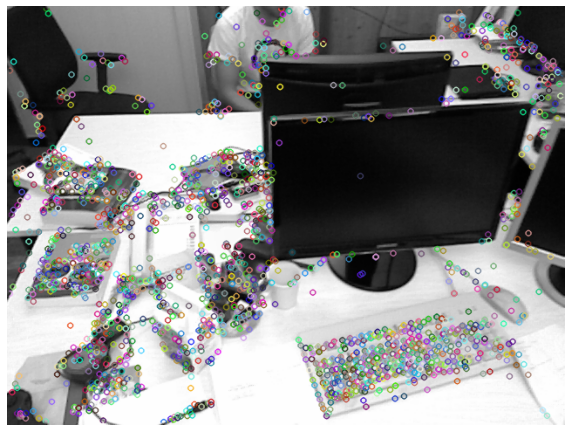

In [3]:
kp, dsc = sift.detectAndCompute(gray, None)

img_with_kp = np.zeros_like(gray)
img_with_kp = cv2.drawKeypoints(gray, kp, img_with_kp)
plt.figure(figsize=(10, 10))
plt.imshow(img_with_kp)
plt.axis('off');

In [4]:
class TUM_dataset():
    def __init__(self, path='./data', step=5, nfeatures=100000):
        images = [cv2.imread(path + '/rgb/' + im) for im in tqdm(os.listdir(path + '/rgb')[::step])]
        
        # build raw keypoints and descriptors data
        sift = cv2.xfeatures2d.SIFT_create(nfeatures=nfeatures)
        self.pts_n_dsc = [sift.detectAndCompute(cv2.cvtColor(im, cv2.COLOR_BGR2GRAY), None) for im in images]
                  
        # build pairs of images to find correspondences
        self.data = list(zip(images[:-1],
                             images[1:]))
                  
    def get_sift_data(self, i):
        return (self.pts_n_dsc[i], self.pts_n_dsc[i+1])
                  
    def __getitem__(self, i):
        return self.data[i]
      
    def __len__(self):
        return len(self.data)
    
def show_pair_ims(pair):
    fig, axs = plt.subplots(1, 2, figsize=(15, 15))
    axs[0].imshow(pair[0])
    axs[0].axis('off');
    axs[1].imshow(pair[1])
    axs[1].axis('off');

In [5]:
data_loader = TUM_dataset()
print(f'Composed a dataset of length {len(data_loader)}')

100%|██████████| 160/160 [00:01<00:00, 106.57it/s]


Composed a dataset of length 159


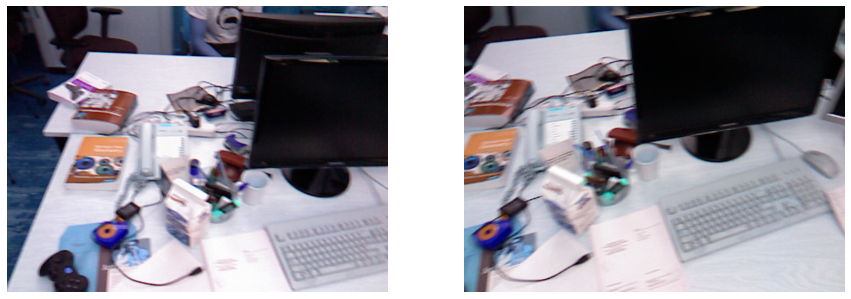

In [6]:
idx = 10#np.random.choice(len(data_loader))
im_left, im_right = data_loader[idx]
show_pair_ims((im_left, im_right))

## SIFT: detect keypoints and create descriptors

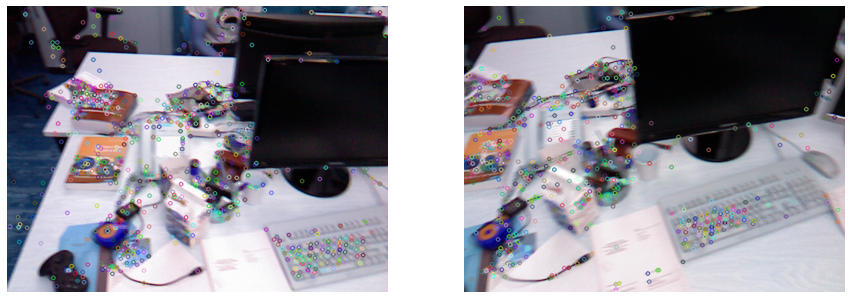

In [7]:
sift_left, sift_right = data_loader.get_sift_data(idx)
sift_left_im = cv2.drawKeypoints(im_left, sift_left[0], None)
sift_right_im = cv2.drawKeypoints(im_right, sift_right[0], None)
show_pair_ims((sift_left_im, sift_right_im))

In [22]:
def to_cv_dmatch(match_indices):
    return list(map(lambda x: cv2.DMatch(x[0], x[1], 0, 0), zip(np.arange(0, len(match_indices)), match_indices)))

def show_matches(im_left, im_right, kp_left, kp_right, corrs, title='Images correspondences'):
    '''
    kp_left, kp_right: key points detected on left and right images, dtype=cv2.KeyPoint
    corrs: array of point correspondences between left and right images, dtype=np.array(int)
    '''
    img_with_matches = cv2.drawMatches(im_left, kp_left, im_right, kp_right, 
                                       to_cv_dmatch(corrs), None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    fig = plt.figure(figsize=(15, 15))
    plt.imshow(img_with_matches)
    plt.axis('off')
    plt.title(title, fontsize=16)
    

## KNN Matcher

In [9]:
corrs = np.zeros(len(sift_left[0]), dtype=int)
for i, pt_l in enumerate(sift_left[0]):
    dsc_l = sift_left[1][i]
    dists = []
    for j, pt_r in enumerate(sift_right[0]):
        dsc_r = sift_right[1][j]
        dists.append(np.linalg.norm(dsc_l - dsc_r, ord=2))
    
    corrs[i] = np.argsort(np.array(dists))[0]


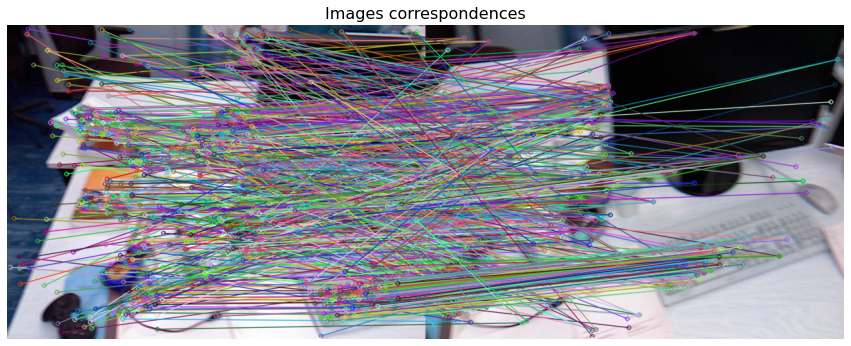

In [23]:
show_matches(im_left, im_right, sift_left[0], sift_right[0], corrs)

## [AdaLam](https://github.com/cavalli1234/AdaLAM) Outlier Filtering




In [12]:
from adalam import AdalamFilter

class adalam_filter():
    def __init__(self):
        self.matcher = AdalamFilter()

    def get_data(self, kps):
        pts = np.array([k.pt for k in kps], dtype=np.float32)
        ors = np.array([k.angle for k in kps], dtype=np.float32)
        scs = np.array([k.size for k in kps], dtype=np.float32)
        
        return pts, ors, scs
    
    def process(self, kp_n_dsc1: tuple, kp_n_dsc2: tuple, imshape: tuple):
        '''
        kp_n_dsc1: (kp_left, dsc_left)
        kp_n_dsc2: (kp_right, dsc_right)
        '''
        pts1, ors1, scs1 = self.get_data(kp_n_dsc1[0])
        pts2, ors2, scs2 = self.get_data(kp_n_dsc2[0]) 

        matches = self.matcher.match_and_filter(k1=pts1, k2=pts2,
                                                o1=ors1, o2=ors2,
                                                d1=kp_n_dsc1[1], d2=kp_n_dsc2[1],
                                                s1=scs1, s2=scs2,
                                                im1shape=imshape[0][:2], im2shape=imshape[1][:2]).cpu().numpy()
        
        return matches

matcher_adalam = adalam_filter()

In [24]:
matches = matcher_adalam.process(sift_left, sift_right, (im_left.shape, im_right.shape))

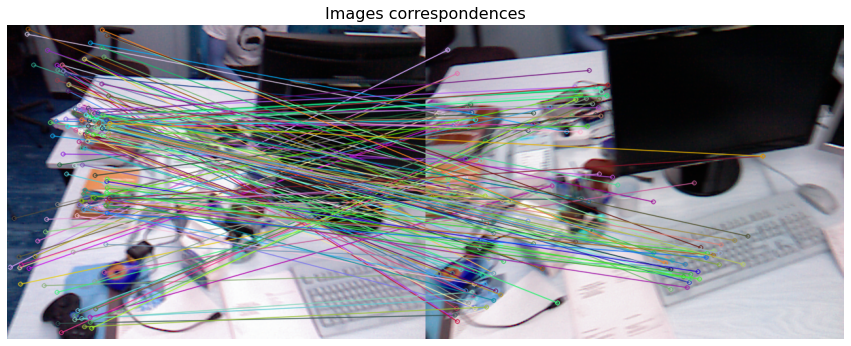

In [26]:
show_matches(im_left, im_right, sift_left[0], sift_right[0], matches[:, 1])